In [1]:
# classical
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from scipy.sparse.linalg import eigsh

# quantum
import qiskit
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import SparsePauliOp, StabilizerState, Clifford, Statevector, Pauli, random_clifford
from qiskit_algorithms import VQE
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import Optimizer, OptimizerSupportLevel, OptimizerResult, COBYLA, SPSA, GradientDescent, ADAM
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.gradients import ReverseEstimatorGradient

### Function Declarations

In [2]:
# generates the circuit diagram
def Diagram(circuit):
    return circuit_drawer(circuit, output="mpl")

### creating PQC models

def create_mHEA(n_qubits, n_layers=3):
    ansatz_circ = EfficientSU2(n_qubits, su2_gates=['ry', 'rz'], entanglement='circular', reps=n_layers, flatten=True)
    n_params = ansatz_circ.num_parameters
    return ansatz_circ, n_params

def create_fHEA(n_qubits, n_layers=3):
    ansatz_circ = EfficientSU2(n_qubits, su2_gates=['rx', 'ry', 'rz'], entanglement='full', reps=n_layers, flatten=True)
    n_params = ansatz_circ.num_parameters
    return ansatz_circ, n_params

### creating observables

def create_H_Heisenberg(l):
    op_list = []
    for i in range(l - 1):
        X_gate = 'I' * i + 'XX' + 'I' * (l - i - 2)
        Y_gate = 'I' * i + 'YY' + 'I' * (l - i - 2)
        Z_gate = 'I' * i + 'ZZ' + 'I' * (l - i - 2)
        op_list.append((X_gate, 1))
        op_list.append((Y_gate, 1))
        op_list.append((Z_gate, 1))
    return SparsePauliOp.from_list(op_list)

def create_globalZ(N):    
    pauli_string = "Z" * N  # Create the Pauli string ZZZ...Z (N times)
    return SparsePauliOp.from_list([(pauli_string, 1)])

def create_global(N):
    return SparsePauliOp.from_list([("X"*N, 1), ("Y"*N, -1/2), ("Z"*N, 1/3)])

def create_H_Ising(l, J=1.0, h=1.0):
    op_list = []
    for i in range(l):
        X_gate = 'I'*i + 'X' + (l-i-1)*'I'
        op_list.append((X_gate, -h))
        if i < l-1:
            Z_gate = 'I'*i + 'ZZ' + (l-i-2)*'I'
            op_list.append((Z_gate, -J))
    op_list.append(('Z' + 'I'*(l-2) + 'Z', -J))
    return SparsePauliOp.from_list(op_list)

# returns a random non-trivial Pauli-string of the form 'IZXYZX' of length N
def RandomPauliString(N):
    pauli_chars = ['I', 'X', 'Y', 'Z']
    Pauli_string = ''.join(random.choice(pauli_chars) for _ in range(N))
    if Pauli_string == N * 'I':
        return RandomPauliString(N)
    return Pauli_string

# returns an observable generated by random, non-trivial, unsigned N-qubit Pauli-strings with I elements
def RandomPauliStrings(N, I=3):
    list = []
    for _ in range(I):
        list.append((RandomPauliString(N), 1))
    return SparsePauliOp.from_list(list)

### auxiliary functions

def compute_expectation(circuit, params, observable):
    
    estimator = Estimator()
    job = estimator.run([circuit], [observable], [params])
    result = job.result()
    
    return result.values[0]  # Extract expectation value

def compute_gradient(circuit, params, observable):

    estimator = Estimator()
    gradient = ReverseEstimatorGradient(estimator)
    # Bind parameters and compute gradients
    job = gradient.run([circuit], [observable], [params])
    result = job.result()
    return result.gradients[0]

def smallest_eigenvalue(H):
    # Convert to sparse matrix
    matrix = H.to_matrix(sparse=True)
    # Compute smallest eigenvalue
    smallest_eigval = eigsh(matrix, k=1, which='SA', return_eigenvectors=False)
    return smallest_eigval[0].real

### custom optimizers

# vanilla gradient descent
def VanillaGradientDescent(ansatz, observable, initial_theta, learning_rate=0.01, number_of_iterations=100):
    D = ansatz.num_parameters
    theta_values, loss_values, gradient_values = [], [], []
    theta = initial_theta.copy()

    for _ in range(number_of_iterations):
        gradient = compute_gradient(ansatz, theta, observable)

        # store values
        theta_values.append(theta.copy())
        loss_values.append(compute_expectation(ansatz, theta, observable))
        gradient_values.append(gradient.copy())

        # update parameters
        theta -= learning_rate * gradient

    return theta_values, loss_values, gradient_values

# ADAM optimizer
def ADAM(ansatz, observable, initial_theta, learning_rate=0.01, number_of_iterations=100, beta1=0.9, beta2=0.999, epsilon=1e-8):
    D = ansatz.num_parameters
    
    theta_values, loss_values, gradient_values = [], [], []
    theta = initial_theta.copy()  # avoid modifying the original input
    m, v = np.zeros(D), np.zeros(D)  # initialize moment estimates
    t = 0  # time step

    for _ in range(number_of_iterations):
        t += 1

        # compute gradients
        gradient = compute_gradient(ansatz, theta, observable)

        # update biased first moment estimate
        m = beta1 * m + (1 - beta1) * gradient

        # update biased second moment estimate
        v = beta2 * v + (1 - beta2) * (gradient**2)

        # compute bias-corrected moments
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        # store values
        theta_values.append(theta.copy())
        loss_values.append(compute_expectation(ansatz, theta, observable))
        gradient_values.append(gradient.copy())

        # update parameters using Adam rule
        theta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

    return theta_values, loss_values, gradient_values

### LCE Subroutines

# takes a parameterized quantum circuit and splits it into two subcircuits at the k-th rotation gate
def split_circuit(circuit, k):
    parameters = list(circuit.parameters) # extract the parameters in the order they appear
    target_param = parameters[k]  # The theta[k] parameter

    # initialize left and right subcircuits
    left_circuit = QuantumCircuit(circuit.num_qubits)
    right_circuit = QuantumCircuit(circuit.num_qubits)

    # iterate over the circuit instructions and distribute them accordingly
    param_found = False  # flag to track when we find the target parameter

    for instruction in circuit.data:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        # check if the instruction has a parameter that matches target_param
        instr_params = instr.params  # parameters of the current gate
        
        if any(isinstance(p, ParameterVector) for p in instr_params):
            continue  # skip parameter vectors (if any)

        # if this instruction has the target parameter
        if target_param in instr_params:
            param_found = True  # we have reached the split point
            continue  # skip adding this gate (since it belongs to theta[k])

        # add the gate to the appropriate subcircuit
        if not param_found:
            left_circuit.append(instr, qargs, cargs)
        else:
            right_circuit.append(instr, qargs, cargs)

    return left_circuit, right_circuit

# takes a PQC and removes all rotation gates (i.e. returns U(0) without including rotation gates)
def remove_zero_rotations(circuit):
    new_circuit = QuantumCircuit(circuit.num_qubits)  # create empty circuit
    
    for instruction in circuit.data:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        if instr.name in ['rx', 'ry', 'rz']:  # check if it is a rotation gate
            param_value = instr.params[0]  # extract parameter value
            
            # remove gate if rotation is exactly zero
            if isinstance(param_value, (int, float)) and np.isclose(param_value, 0):
                continue  # skip adding this gate

        # otherwise, add the instruction
        new_circuit.append(instr, qargs, cargs)

    return new_circuit

# take a PQC and returns the rotation axis 'X', 'Y', or 'Z' of the k-th rotation gate, and the qubit index on which the rotation is acting on
def get_rotation_axis(circuit, k):
    param_count = 0  # track parameter index
    
    for instruction in circuit.data:
        gate = instruction.operation
        qargs = instruction.qubits
        if gate.name in ["rx", "ry", "rz"]:  # check if it is a rotation gate
            num_params = len(gate.params)
            if num_params > 0:
                if param_count == k:
                    qubit_index = circuit.qubits.index(qargs[0])
                    return gate.name[-1].upper(), qubit_index  # extract X, Y, or Z
                param_count += 1

# constructs the Q_tilde circuit which induces a relative phase between the shifted evolved Pauli strings
def phase_inducer(circuit, k, pauli_string):
    N = circuit.num_qubits
    Q_tilde = QuantumCircuit(N)
    W = QuantumCircuit(N)
    V, j = get_rotation_axis(circuit, k)
    pauli_string = pauli_string.replace('-','')
    _, W_a = split_circuit(circuit, k)
    W_a = remove_zero_rotations(W_a.assign_parameters(np.zeros(W_a.num_parameters)))

    pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
    if pauli_string[j] != 'I':
        if V != pauli_string[j]:
            return W_a.inverse()
        
        if V == pauli_string[j]:
            if V == 'X' or V == 'Z':
                W.h(j)
            if V == 'Y':
                W.s(j)
            return W_a.inverse().compose(W)
        
    if pauli_string[j] == 'I':
        W_1 = QuantumCircuit(N)
        for idx in range(N):
            if pauli_string[idx] != 'I':
                i = idx
                break
        if pauli_string[i] == 'X' or pauli_string[i] == 'Y':
            W_1.cx(i, j)
        if pauli_string[i] == 'Z':
            W_1.cx(j, i)
        
        pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
        P_W = Pauli(pauli_string).evolve(Clifford(W_1))
        pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention

        if V != str(P_W[j]):
            return W_a.inverse().compose(W_1)

        if V == str(P_W[j]):
            W_2 = QuantumCircuit(N)
            if V == 'X' or V == 'Z':
                W_2.h(j)
            if V == 'Y':
                W_2.s(j)
            return W_a.inverse().compose(W_2.compose(W_1))

# constructs the Q circuit which diagonalizes the shifted evolved Pauli strings
def diagonalizer(circuit, pauli_string):
    N = circuit.num_qubits
    Q = QuantumCircuit(N)
    pauli_string = pauli_string.replace('-','')

    pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
    for j in range(N):
        if pauli_string[j] == 'X':
            Q.h(j)
        if pauli_string[j] == 'Y':
            Q.h(j)
            Q.s(j)

    return Q

# takes the PQC, the input Pauli-string and the desired components k\in[D], and returns the Clifford-modified PQC with scalable gradients
def LinearCliffordEncoder(circuit, pauli_string, k):
    D = circuit.num_parameters
    Q_tilde = phase_inducer(circuit, k, pauli_string)
    circuit.barrier()
    U = circuit.compose(Q_tilde)

    P_tilde_0_ek = str(Pauli(pauli_string).evolve(Clifford(U.assign_parameters(np.eye(D)[k] * np.pi/2))))
    P_tilde_ek_ek = str(Pauli(pauli_string).evolve(Clifford(U.assign_parameters(-np.eye(D)[k] * np.pi/2)))) ###
    #print("phased Pauli shifts:", P_tilde_0_ek, P_tilde_ek_ek) ###

    Q = diagonalizer(U, P_tilde_0_ek)
    Q.barrier()
    U = Q.compose(U)

    #print("diagonalized Pauli shifts:", Pauli(pauli_string).evolve(Clifford(U.assign_parameters(np.eye(D)[k] * np.pi/2))), ###
      #Pauli(pauli_string).evolve(Clifford(U.assign_parameters(-np.eye(D)[k] * np.pi/2)))) ###

    return U

# picks the optimal Pauli-term and direction k\in[D] such that the cost is minimal at theta=0
def MinimalLCE(circuit, observable):
    D = circuit.num_parameters
    minimal_cost = np.inf
    optimal_pauli_string = None
    optimal_k = None
    
    # Iterate over all possible combinations
    for k in range(D):
        for pauli_string in observable.paulis:
            circuit_LCE = LinearCliffordEncoder(circuit, str(pauli_string), k)
            cost_LCE = compute_expectation(circuit_LCE, np.zeros(D), observable)

            if cost_LCE < minimal_cost:
                minimal_cost = cost_LCE  # Update minimal cost
                optimal_pauli_string = pauli_string
                optimal_k = k
    
    return optimal_pauli_string, optimal_k


In [138]:
N = 8
L = 5
k = 0

number_of_runs = 10

U = EfficientSU2(N, su2_gates=[ 'ry', 'rz'], entanglement='circular', reps=L, flatten=True) # mHEA-model
D = U.num_parameters

pauli_string = 'Z' * N
#observable = create_H_Heisenberg(N)
#pauli_string = str(observable.paulis[0])
#pauli_string = RandomPauliString(N)
print("input Pauli:", pauli_string)

U_LCE = LinearCliffordEncoder(U, pauli_string, k) # update with LinearCliffordEncoder (LCE)

n_thetas = 100
theta_k_values = np.linspace(-np.pi, np.pi, n_thetas)

all_costs = np.zeros((number_of_runs, n_thetas))
all_costs_LCE = np.zeros((number_of_runs, n_thetas))

for run in range(number_of_runs):
    # fix the random seed for reproducibility
    np.random.seed(run)
    theta = np.random.normal(-1/np.sqrt(D), 1/np.sqrt(D), size=D)

    for i, x in enumerate(theta_k_values):
        theta[k] = x
        all_costs[run, i]     = compute_expectation(U,     theta, pauli_string)
        all_costs_LCE[run, i] = compute_expectation(U_LCE, theta, pauli_string)

# Compute mean and std over runs, for each theta_k
mean_cost     = all_costs.mean(axis=0)
std_cost      = all_costs.std(axis=0)
mean_cost_LCE = all_costs_LCE.mean(axis=0)
std_cost_LCE  = all_costs_LCE.std(axis=0)

input Pauli: ZZZZZZZZ


C:\Users\desuvo18\AppData\Local\Temp\ipykernel_18220\1744252898.py:63: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


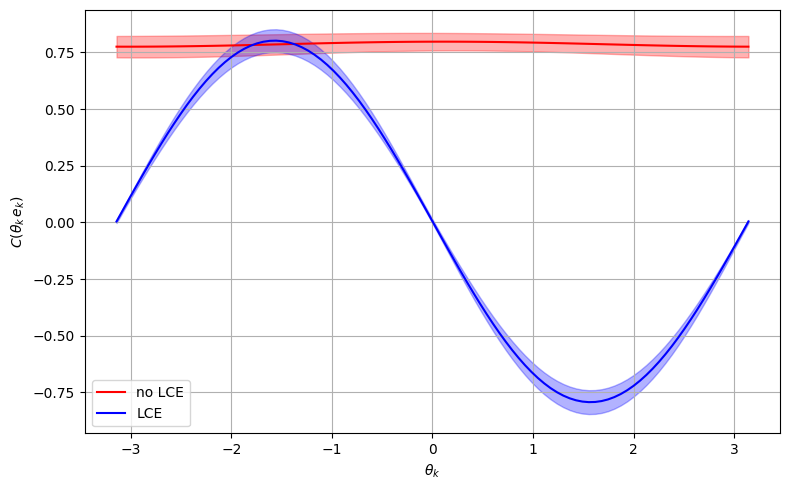

In [139]:
# Plot
plt.figure(figsize=(8, 5))

# No-LCE curve + shaded ±1 std
plt.plot(theta_k_values, mean_cost, label='no LCE', color='red')
plt.fill_between(theta_k_values,
                 mean_cost - std_cost,
                 mean_cost + std_cost,
                 color='red', alpha=0.3)

# LCE curve + shaded ±1 std
plt.plot(theta_k_values, mean_cost_LCE, label='LCE', color='blue')
plt.fill_between(theta_k_values,
                 mean_cost_LCE - std_cost_LCE,
                 mean_cost_LCE + std_cost_LCE,
                 color='blue', alpha=0.3)

plt.xlabel(r'$\theta_k$')
plt.ylabel(r'$C(\theta_k\,e_k)$')
#plt.title(f'Average cost over {number_of_runs} runs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [102]:
### Comparing Height Maps

N = 12
L = 6
k = 0
k_other = 2


U = EfficientSU2(N, su2_gates=[ 'ry', 'rz'], entanglement='circular', reps=L, flatten=True) # mHEA-model
D = U.num_parameters
print("D:", D)
pauli_string = 'Z' * N
#observable = create_H_Heisenberg(N)
#pauli_string = str(observable.paulis[0])
#pauli_string = RandomPauliString(N)
print("input Pauli:", pauli_string)

U_LCE = LinearCliffordEncoder(U, pauli_string, k) # update with LinearCliffordEncoder (LCE)

n_thetas = 30
theta_k_values = np.linspace(-np.pi, np.pi, n_thetas)
theta_k_other_values = np.linspace(-np.pi, np.pi, n_thetas)

all_costs = np.zeros((n_thetas, n_thetas))
all_costs_LCE = np.zeros((n_thetas, n_thetas))

theta = np.zeros(D)

for i, x in enumerate(theta_k_values):
    for j, y in enumerate(theta_k_other_values):
        theta[k] = x
        theta[k_other] = y
        all_costs[j, i]     = compute_expectation(U,     theta, pauli_string)
        all_costs_LCE[j, i] = compute_expectation(U_LCE, theta, pauli_string)

#Diagram(U_LCE)

D: 168
input Pauli: ZZZZZZZZZZZZ


C:\Users\desuvo18\AppData\Local\Temp\ipykernel_16572\3398555793.py:67: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


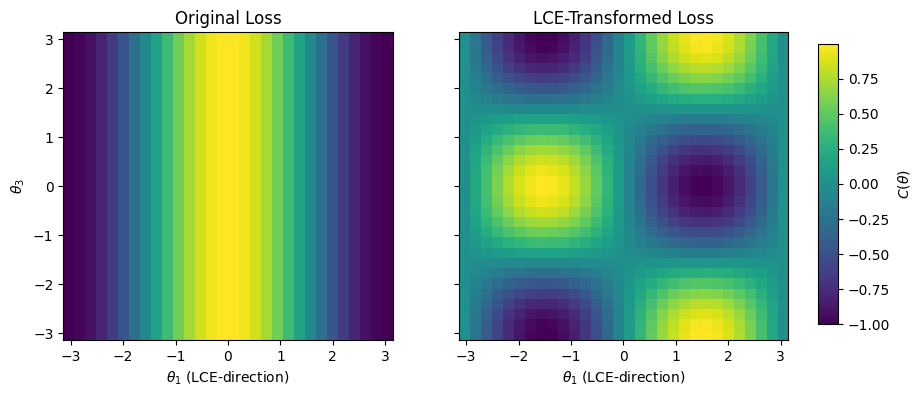

In [103]:
# Create the meshgrid for plotting
X, Y = np.meshgrid(theta_k_values, theta_k_other_values)

# Plot the heightmaps with shared axes
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot the original cost landscape
img1 = axs[0].imshow(all_costs, extent=[-np.pi, np.pi, -np.pi, np.pi],
                     origin='lower', cmap='viridis', aspect='auto')
axs[0].set_title("Original Loss")
axs[0].set_xlabel(f"$\\theta_{{{k+1}}}$ (LCE-direction)")
axs[0].set_ylabel(f"$\\theta_{{{k_other+1}}}$")

# Plot the LCE-encoded cost landscape
img2 = axs[1].imshow(all_costs_LCE, extent=[-np.pi, np.pi, -np.pi, np.pi],
                     origin='lower', cmap='viridis', aspect='auto')
axs[1].set_title("LCE-Transformed Loss")
axs[1].set_xlabel(f"$\\theta_{{{k+1}}}$ (LCE-direction)")
#axs[1].set_ylabel(f"$\\theta_{{{k_other+1}}}$")

# Adjust layout to make space for colorbar
fig.subplots_adjust(right=0.85)

# Add one colorbar on the right side
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(img1, cax=cbar_ax).set_label(r"$C(\theta)$")

plt.show()


In [104]:
### Comparing Height Maps (averaging over all non-LCE direction parameters)

N = 12
L = 6
k = 0


U = EfficientSU2(N, su2_gates=[ 'ry', 'rz'], entanglement='circular', reps=L, flatten=True) # mHEA-model
D = U.num_parameters
print("D:", D)
pauli_string = 'Z' * N
#observable = create_H_Heisenberg(N)
#pauli_string = str(observable.paulis[0])
#pauli_string = RandomPauliString(N)
print("input Pauli:", pauli_string)

U_LCE = LinearCliffordEncoder(U, pauli_string, k) # update with LinearCliffordEncoder (LCE)

n_thetas = 30
theta_k_values = np.linspace(-np.pi, np.pi, n_thetas)
theta_k_other_values = np.linspace(-np.pi, np.pi, n_thetas)

results = []

for k_other in range(D):
    if k_other == k:
        continue

    all_costs = np.zeros((n_thetas, n_thetas))
    all_costs_LCE = np.zeros((n_thetas, n_thetas))

    theta = np.zeros(D)

    for i, x in enumerate(theta_k_values):
        for j, y in enumerate(theta_k_other_values):
            theta[k] = x
            theta[k_other] = y
            all_costs[j, i] = compute_expectation(U, theta, pauli_string)
            all_costs_LCE[j, i] = compute_expectation(U_LCE, theta, pauli_string)

    results.append((k_other, all_costs, all_costs_LCE))

# Save intermediate data
with open('data_LCE-height-map.pkl', 'wb') as f:
    pickle.dump(results, f)


D: 168
input Pauli: ZZZZZZZZZZZZ


C:\Users\desuvo18\AppData\Local\Temp\ipykernel_16572\3398555793.py:67: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


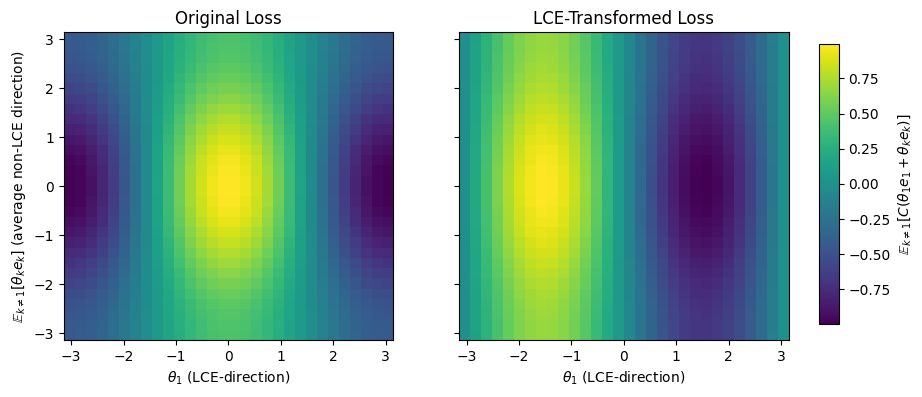

In [3]:
# Load the saved height map data
with open('data_LCE-height-map.pkl', 'rb') as f:
    results = pickle.load(f)

k = 0
n_thetas = 30
theta_k_values = np.linspace(-np.pi, np.pi, n_thetas)
theta_k_other_values = np.linspace(-np.pi, np.pi, n_thetas)

# Initialize accumulators
n_variants = len(results)
shape = results[0][1].shape  # Assuming all all_costs have same shape

sum_all_costs = np.zeros(shape)
sum_all_costs_LCE = np.zeros(shape)

# Accumulate results
for k_other, all_costs, all_costs_LCE in results:
    sum_all_costs += all_costs
    sum_all_costs_LCE += all_costs_LCE

# Compute averages
average_all_costs = sum_all_costs / n_variants
average_all_costs_LCE = sum_all_costs_LCE / n_variants

# Create the meshgrid for plotting
X, Y = np.meshgrid(theta_k_values, theta_k_other_values)

# Plot the heightmaps with shared axes
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot the original cost landscape
img1 = axs[0].imshow(average_all_costs, extent=[-np.pi, np.pi, -np.pi, np.pi],
                     origin='lower', cmap='viridis', aspect='auto')
axs[0].set_title("Original Loss")
axs[0].set_xlabel(f"$\\theta_{{{k+1}}}$ (LCE-direction)")
#axs[0].set_ylabel(r"$\overline{\theta}$")

# Plot the LCE-encoded cost landscape
img2 = axs[1].imshow(average_all_costs_LCE, extent=[-np.pi, np.pi, -np.pi, np.pi],
                     origin='lower', cmap='viridis', aspect='auto')
axs[1].set_title("LCE-Transformed Loss")
axs[1].set_xlabel(f"$\\theta_{{{k+1}}}$ (LCE-direction)")
axs[0].set_ylabel(rf"$\mathbb{{E}}_{{k\neq {k+1}}}[\theta_k e_k]$ (average non-LCE direction)")

# Adjust layout to make space for colorbar
fig.subplots_adjust(right=0.85)

# Add one colorbar on the right side
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(img1, cax=cbar_ax).set_label(rf"$\mathbb{{E}}_{{k\neq {k+1}}}[C(\theta_{k+1}e_{k+1}+\theta_k e_k)]$")
plt.savefig("LCE-heightmap.pdf", format="pdf")
plt.show()
